In [268]:
# Import of the pyomo module
import os, sys
import pandas as pd
import numpy as np
from pyomo.environ import *
# from pyomo.core import *

In [269]:
# Creation of a Concrete Model
model = ConcreteModel()

number_of_weeks = 6

In [270]:
  
C = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10']   
I = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [271]:
# Sets

## C    set of customers   / c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 /
## I    set of products    /  A,  B,  C,  D,  E,  F,  G,  H,  I,   J /
## W    set of weeks       / w1, w2, w3, w4, w5, w6, w7, w8 /
## Wa   set W without week 1

# Alias  (I, J);

model.C = Set(initialize=C)
model.I = Set(initialize=I)
model.J = Set(initialize=I)
model.Ia = Set(initialize=I[1:])
model.Ja = Set(initialize=I[1:])

W = ['w%i' % w for w in range(1, number_of_weeks + 1)]
model.W = Set(initialize=W)
model.Wa = Set(initialize=W[1:])
model.Wdict = {W[1:][k]: W[:-1][k] for k in range(number_of_weeks - 1)}

In [272]:
# Scalars

## M         'Big M'  / 100000 /
## ThetaL    'lower bound for processing time in a week [h]'  / 5.0 /
## ThetaU    'upper bound for processing time in a week [h]' / 168.0 /

model.M      = 10000.0
model.ThetaL = 5.0
model.ThetaU = 168.0

In [273]:
# Tables

weekly_demand = pd.read_excel('Table_1_Weekly_Demands_by_the_Customers.xlsx').fillna(0)
weekly_demand_row = weekly_demand.index
weekly_demand_row = pd.MultiIndex.from_tuples([tuple(idx.split(".")) for idx in weekly_demand_row], names=['C','I'])
weekly_demand_col = weekly_demand.columns
weekly_demand = pd.DataFrame(data=weekly_demand.values,
                             index=weekly_demand_row,
                             columns=weekly_demand_col)

changeover_times = pd.read_excel('Table_2_Changeover_Times.xlsx').fillna(0)
changeover_times = changeover_times / 60.0 # Convert units from mins to hrs

weekly_sales = pd.read_excel('Table_5a_Optimal_Weekly_Aggregate_Sales.xlsx').convert_objects(convert_numeric=True).fillna(0)

weekly_backlogs = pd.read_excel('Table_5b_Optimal_Weekly_Aggregate_Backlogs.xlsx').convert_objects(convert_numeric=True).fillna(0)

C:\Users\zhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\zhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [274]:
# Parameters

## PS(i, c)  'unit selling price of product i [$/ton]'
## Table 3 shows the product prices for all customers, except for customer C10, who is 50% higher
PSdict1d = {'A': 10., 'B': 12., 'C': 13., 'D': 12., 'E': 15., 'F': 10., 'G': 8., 'H': 14., 'I': 7., 'J': 15.}
def PSinit(model, i, c):
    if c == 'c10':
        return PSdict1d[i] * 1.5
    else:
        return PSdict1d[i]
model.PS = Param(model.I, model.C, initialize=PSinit)

## r(i)      'processing rate of product i [ton/week]'
model.r = Param(model.I, initialize={i: 110.0 / 168.0 for i in model.I})

## CB(i, c)  'unit backlog penalty cost of product i to customer c [$/ton]'
## The ... backlog cost [is] ... 20% of product prices.
def CBinit(model, i, c):
    if c == 'c10':
        return PSdict1d[i] * 0.3
    else:
        return PSdict1d[i] * 0.2
model.CB = Param(model.I, model.C, initialize=CBinit)

## CI(i)     'unit inventory cost of product i [$/ton]'
## The ... inventory cost [is] ... 10% of product prices.
def CIinit(model, i):
    return PSdict1d[i] * 0.1
model.CI = Param(model.I, initialize=CIinit)

## tau(i, j) 'changeover time from product i to product j [hours]'
taudict = changeover_times.stack().to_dict()
model.tau = Param(model.I, model.J, initialize=taudict)

## CC(i, j)  'changeover cost from product i to product j [$]'
def CCinit(model, i, j):
    return taudict[i, j] * 10.0
model.CC = Param(model.I, model.J, initialize=CCinit)

## D(c,i,w)  'demand of product i in week w from customer c [ton]'
def Dinit(model, c, i, w):
    return weekly_demand.loc[c, i].loc[w]
model.D = Param(model.C, model.I, model.W, initialize=Dinit)

#  Vmax(i)   'maximum storage space for product i [ton]'
#  Not explicitly defined in Liu et al.'s paper
#  If maximum storage exceeds maximum production, then result is 
#    infeasible
model.Vmax = Param(model.I, initialize={i: 110.0 for i in model.I})

#  Vmin(i)   'minimum storage requirement for product i [ton]'
model.Vmin = Param(model.I, initialize={i: 0.0 for i in model.I})


In [275]:
# Binary Variables

## E(i, w)   '1 if product i is processed during week w'
## F(i, w)   '1 if product i is the first one in week w'
## L(i, w)   '1 if product i is the last one in week w'
## Z(i,j,w)  '1 if product i immediately precedes product j during week w'
## ZF(i,j,w) '1 if the changeover between weeks w - 1 and w is from product i to j'

model.E = Var(model.I, model.W, domain=Boolean, initialize=0)
model.F = Var(model.I, model.W, domain=Boolean, initialize=0)
model.L = Var(model.I, model.W, domain=Boolean, initialize=0)
model.Z = Var(model.I, model.J, model.W, domain=Boolean, initialize=0)
model.ZF = Var(model.I, model.J, model.W, bounds=(0, 1), initialize=0)

In [276]:
# Other Variables

## O(i, w)   'order index of product i during week w'
## P(i, w)   'amount of product i produced during week w'
## S(c,i,w)  'sales volume of product i to customer c during week w'
## T(i, w)   'processing time of product i during week w'
## V(i, w)   'inventory volume of product i at the end of week w'
## Delta(c,i,w)  'backlog of product i to customer c at the end of week w'

model.O = Var(model.I, model.W, initialize=0, domain=Integers)
model.P = Var(model.I, model.W, initialize=0.0, domain=NonNegativeReals)
model.S = Var(model.C, model.I, model.W, initialize=0.0, domain=NonNegativeReals)
model.T = Var(model.I, model.W, initialize=0.0, domain=NonNegativeReals)
model.V = Var(model.I, model.W, initialize=0.0, domain=NonNegativeReals)
model.Delta = Var(model.C, model.I, model.W, initialize=0.0, domain=NonNegativeReals)


In [277]:
# Objective [Eq. 1]
## Pi        'total profit'

def Eq1(model):
    revenue = sum(model.PS[i,c] * model.S[c,i,w]
                  for w in model.W 
                  for i in model.I
                  for c in model.C)
    cgov_within_week = sum(model.CC[i,j] * model.Z[i,j,w]
                           for j in model.J
                           for i in model.I if i != j
                           for w in model.W)
    cgov_between_weeks = sum(model.CC[i,j] * model.ZF[i,j,w]
                             for j in model.J
                             for i in model.I if i != j
                             for w in model.Wa)
    backlog_penalty = sum(model.CB[i,c] * model.Delta[c,i,w]
                          for i in model.I
                          for c in model.C
                          for w in model.W)
    inventory_cost = sum(model.CI[i] * model.V[i,w]
                         for i in model.I
                         for w in model.W)
    model.profits = revenue - cgov_within_week - cgov_between_weeks - backlog_penalty - inventory_cost
    return model.profits

model.Pi = Objective(rule=Eq1, sense=maximize)

In [278]:
#Assignment Constraints [Eqs. 2 - 5]

## Assignment1 [Eq. 2]
def Assignment1(model, w):
    return (sum(model.F[i,w] for i in model.I) == 1)
model.Eq2 = Constraint(model.W, rule=Assignment1)

## Assignment2 [Eq. 3]
def Assignment2(model, w):
    return (sum(model.L[i,w] for i in model.I) == 1)
model.Eq3 = Constraint(model.W, rule=Assignment2)

## Assignment3 [Eq. 4]
def Assignment3(model, i, w):
    return (model.F[i,w] <= model.E[i,w])
model.Eq4 = Constraint(model.I, model.W, rule=Assignment3)

## Assignment4 [Eq. 5]
def Assignment4(model, i, w):
    return (model.L[i,w] <= model.E[i,w])
model.Eq5 = Constraint(model.I, model.W, rule=Assignment4)

In [279]:
# Changeover Constraints [Eqs. 6 - 9]

## Changeover1 [Eq. 6]
def Changeover1(model, j, w):
    return (sum(model.Z[i,j,w] for i in model.I if i != j) == model.E[j,w] - model.F[j,w])
model.Eq6 = Constraint(model.J, model.W, rule=Changeover1)

## Changeover2 [Eq. 7]
def Changeover2(model, i, w):
    return (sum(model.Z[i,j,w] for j in model.J if i != j) == model.E[i,w] - model.L[i,w])
model.Eq7 = Constraint(model.I, model.W, rule=Changeover2)

## Changeover3 [Eq. 8]
def Changeover3(model, j, w):
    return (sum(model.ZF[i,j,w] for i in model.I) == model.F[j,w])
model.Eq8 = Constraint(model.J, model.Wa, rule=Changeover3)

## Changeover4 [Eq. 9]
def Changeover4(model, i, w):
    return (sum(model.ZF[i,j,w] for j in model.J) == model.L[i,model.Wdict[w]])
model.Eq9 = Constraint(model.I, model.Wa, rule=Changeover4)

In [280]:
# Subtour Elimination Constraints [Eqs. 10 - 12]
## SubtourElim1a - New Constraint, replaces [Eq. 10]
def SubtourElim1a(model, i, j, w):
    if i != j:
        return ((model.O[i,w] - model.O[j, w] + model.M * model.Z[i,j,w]
                + (model.M - 2) * model.Z[j,i,w]) <= model.M - 1)
    else: # Evaluates to True
        return (model.O[j,w] == model.O[i,w])
model.DL1 = Constraint(model.Ia, model.Ja, model.W, rule=SubtourElim1a)
# model.Wa instead?

def SubtourElim1b(model, i, w):
    return (model.O[i,w] >= (1 + (model.M - 2) * model.Z[i,'A',w] + 
                            sum(model.Z[j,i,w] for j in model.Ja if i != j)))
model.DL2 = Constraint(model.Ia, model.W, rule=SubtourElim1b)

def SubtourElim1c(model, i, w):
    return (model.O[i,w] <= (model.M - (model.M - 2) * model.Z['A',i,w] - 
                             sum(model.Z[i,j,w] for j in model.Ja if i != j)))
model.DL3 = Constraint(model.Ia, model.W, rule=SubtourElim1c)

## SubtourElim2 [Eq. 11]
def SubtourElim2(model, i, w):
    return (model.O[i,w] <= model.M * model.E[i,w])
model.Eq11 = Constraint(model.I, model.W, rule=SubtourElim2)

## SubtourElim3 [Eq. 12a]
def SubtourElim3(model, i, w):
    return (model.F[i,w] <= model.O[i,w])
model.Eq12a = Constraint(model.I, model.W, rule=SubtourElim3)

## SubtourElim4 [Eq. 12b]
def SubtourElim4(model, i, w):
    return (model.O[i,w] <= sum(model.E[j,w] for j in model.J))
model.Eq12b = Constraint(model.I, model.W, rule=SubtourElim4)


In [281]:
# Timing Constraints [Eqs. 13 - 15]

## Timing1a [Eq. 13a]
def Timing1a(model, i, w):
    return (model.ThetaL * model.E[i,w] <= model.T[i,w])
model.Eq13a = Constraint(model.I, model.W, rule=Timing1a)

## Timing1b [Eq. 13b]
def Timing1b(model, i, w):
    return (model.T[i,w] <= model.ThetaU * model.E[i,w])
model.Eq13b = Constraint(model.I, model.W, rule=Timing1b)

## Timing2 [Eq. 14 - 15 Combined]
## The constraint formulae given by Liu et al.'s paper is logically
##   incorrect here. A constraint i != j constraint exists for model.Z, 
##   but not for model.ZF. So we break the summation into two parts.
def Timing2(model, w):
    proc_time = sum(model.T[i,w] for i in model.I)
    if w == 'w1':
        cgov_time = sum(model.Z[i,j,w] * model.tau[i,j]
                        for i in model.I
                        for j in model.J if i != j)
    else:
        cgov_time = (sum(model.Z[i,j,w] * model.tau[i,j]
                         for i in model.I
                         for j in model.J if i != j) + 
                     sum(model.ZF[i,j,w] * model.tau[i,j]
                         for i in model.I
                         for j in model.J))
    # print('proc_time:', proc_time, 'week:', w)
    # print('cgov_time:', cgov_time, 'weel:', w)
    return (proc_time + cgov_time <= model.ThetaU)
model.Eq14 = Constraint(model.W, rule=Timing2)


In [282]:
# Production Constraints

## ProdConstraint [Eq. 16]
def ProdConstraint(model, i, w):
    return (model.P[i,w] == model.r[i] * model.T[i,w])
model.Eq16 = Constraint(model.I, model.W, rule=ProdConstraint)


In [283]:
# Backlog Constraints

## BacklogConstraint [Eq. 17]
def BacklogConstraint(model, c, i, w):    
    if w == 'w1':
        return (model.Delta[c,i,w] == model.D[c,i,w] - model.S[c,i,w])
    else:
        return (model.Delta[c,i,w] == model.Delta[c,i,model.Wdict[w]] + model.D[c,i,w] - model.S[c,i,w])
model.Eq17 = Constraint(model.C, model.I, model.W, rule=BacklogConstraint)

In [284]:
# Inventory Constraints [Eqs. 18 - 19]

## Inventory1 [Eq. 18]
def Inventory1(model, i, w):
    if w == 'w1':
        return (model.V[i,w] == model.P[i,w] - sum(model.S[c,i,w] for c in model.C))
    else:
        return (model.V[i,w] == model.V[i,model.Wdict[w]] + model.P[i,w] - sum(model.S[c,i,w] for c in model.C))
model.Eq18 = Constraint(model.I, model.W, rule=Inventory1)

## Inventory2a [Eq. 19a]
def Inventory2a(model, i, w):
    return (model.Vmin[i] <= model.V[i,w])
model.Eq19a = Constraint(model.I, model.W, rule=Inventory2a)

## Inventory2b [Eq. 19b]
def Inventory2b(model, i, w):
    return (model.V[i,w] <= model.Vmax[i])
model.Eq19b = Constraint(model.I, model.W, rule=Inventory2b)

In [285]:
filename = os.path.join(os.path.dirname("__file__"), 'model_original.lp')
model.write(filename, io_options={'symbolic_solver_labels': True})

('model_original.lp', 1568386624536)

In [286]:
opt = SolverFactory('cplex')
opt.options['1030'] = 0 # Turns off presolve
opt.options['1014'] = '1e-9'
opt.solve(model, tee=True, symbolic_solver_labels=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.9.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2019.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\zhang\AppData\Local\Temp\tmpx07hq010.cplex.log' open.
CPLEX> New value for 1030: 0
CPLEX> New value for 1014: 1e-09
CPLEX> Problem 'C:\Users\zhang\AppData\Local\Temp\tmps708v43p.pyomo.lp' read.
Read time = 0.02 sec. (0.31 ticks)
CPLEX> Problem name         : C:\Users\zhang\AppData\Local\Temp\tmps708v43p.pyomo.lp
Objective sense      : Maximize
Variables            :    2661  [Nneg: 1381,  Box: 500,  Binary: 720,
                                 General Integer: 60]
Objective nonzeros   :    2250
Linear constraints   :    2093  [Less: 1026,  Greater: 60,  Equal: 1007]
  Nonzeros       

{'Problem': [{'Name': 'tmps708v43p', 'Lower bound': 7765.352380952545, 'Upper bound': 7766.1257937, 'Number of objectives': 1, 'Number of constraints': 2093, 'Number of variables': 2661, 'Number of nonzeros': 10489, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': 2.67, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal, tolerance (0.0001/1e-06)\\x3a Objective = 7.7653523810e+03', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 216, 'Number of created subproblems': 216}}, 'Error rc': 0, 'Time': 2.9598653316497803}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [287]:
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(model)

w1 ['A', 'H', 'B', 'I', 'D', 'E', 'G', 'C', 'F', 'J']
w2 ['J', 'F', 'B', 'H', 'I', 'D', 'E', 'G', 'C']
w3 ['A', 'H', 'B', 'I', 'D', 'E', 'G', 'C', 'F', 'J']
w4 ['J', 'F', 'B', 'H', 'I', 'D', 'E', 'G', 'C']
w5 ['A', 'H', 'B', 'I', 'D', 'E', 'G', 'C', 'F', 'J']
w6 ['J', 'F', 'B', 'H', 'I', 'D', 'E', 'G', 'C']


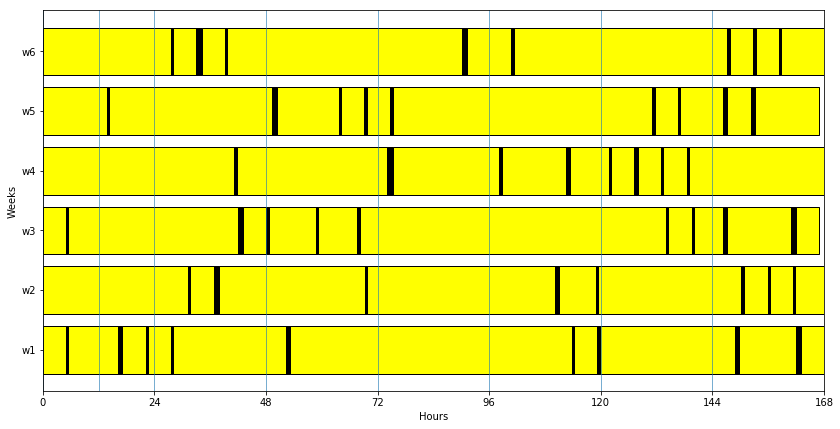

In [290]:
# Visualizing the Results
## Visualizing the Optimal Production Schedule

import itertools
import matplotlib.pyplot as plt

O_out = pd.DataFrame.from_dict(model.O.extract_values(), orient='index', columns=['ColumnName'])
O_out = pd.DataFrame(data=O_out.values.reshape(10, number_of_weeks).T,
                     index=W, columns=I).astype('int64')

T_out = pd.DataFrame.from_dict(model.T.extract_values(), orient='index', columns=[''])
T_out = pd.DataFrame(data=T_out.values.reshape(10, number_of_weeks).T,
                     index=W, columns=I)

O_out[O_out == 0] = 100000
O_out_zerocounts = (O_out == 100000).astype(int).sum(axis=1)
T_out_zerocounts = (T_out == 0).astype(int).sum(axis=1)

prodSchedule = []

for idx, w in enumerate(O_out.index):
    lenempty = O_out.loc[w].isin([model.M]).sum
    prodOrder = [x for _, x in sorted(zip(list(O_out.loc[w]), I))][:len(I)-O_out_zerocounts[idx]]
    print(w, prodOrder)
    orderedProdTime = [x for _, x in sorted(zip(list(O_out.loc[w]), T_out.loc[w]))][:len(I)-T_out_zerocounts[idx]]
    # print(orderedProdTime)

    cgovIdxs = list(zip(prodOrder[:-1], prodOrder[1:]))
    orderedGapTime = [model.tau[pair] for pair in cgovIdxs]
    # print(orderedGapTime)
    
    orderedTime = [x for x in itertools.chain(*itertools.zip_longest(orderedProdTime, orderedGapTime)) if x is not None]
    prodSchedule.append(orderedTime)
    
productionSchedule = np.zeros([len(prodSchedule),len(max(prodSchedule,key = lambda x: len(x)))])
for idx, row in enumerate(prodSchedule):
    productionSchedule[idx][0:len(row)] = row


plt.figure(figsize=(14,7))
# barsheight = np.sum(productionSchedule, axis=1)
barsheight = productionSchedule[:, 0] * 0

for line in range(0, 168 + 24, 24):
    plt.axvline(x=line, linewidth=0.6)
plt.axvline(x=12.0, linewidth=0.6)
    
for idx, ba in enumerate(productionSchedule.T):
    if idx % 2:
        barcolor = 'black'
        edgecolor = 'black'
    else:
        barcolor = 'yellow'
        edgecolor = 'black'
    plt.barh(W, ba, left=barsheight,color=barcolor,edgecolor=edgecolor)
    barsheight = np.add(barsheight, ba)

x_ticks = list(range(0, 168 + 24, 24))
plt.xticks(x_ticks)
plt.xlabel('Hours')
plt.ylabel('Weeks')
plt.savefig('images/SchedulingUsingTSP_DL_%iweeks.png' % number_of_weeks)
plt.show()



In [289]:
O_out

,A,B,C,D,E,F,G,H,I,J
w1,1,2,7,4,5,8,6,1,3,9
w2,100000,3,9,6,7,2,8,4,5,1
w3,1,2,7,4,5,8,6,1,3,9
w4,100000,3,9,6,7,2,8,4,5,1
w5,1,2,7,4,5,8,6,1,3,9
w6,100000,3,9,6,7,2,8,4,5,1
